## Problem Statement.

## Import required packages.

In [1]:
%matplotlib inline

# data manuipulation
import numpy as np
import pandas as pd

# modeling utilities
import pydotplus 
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


# plotting libraries
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sn


sn.set_style('whitegrid')
sn.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

## Load Dataset.

In [2]:
hour_df = pd.read_csv('hour.csv')
print("Shape of dataset::{}".format(hour_df.shape))

Shape of dataset::(17379, 17)


## Preprocessing.

##### 1. Standarize column names.
##### 2. Typecast attributes.
##### 3. Encode Categoricals using One Hot Encoding.

## Standarize Column Names.

In [3]:
hour_df.rename(columns={'instant':'rec_id',
                      'dteday':'datetime',
                      'holiday':'is_holiday',
                      'workingday':'is_workingday',
                      'weathersit':'weather_condition',
                      'hum':'humidity',
                       'mnth':'month',
                      'cnt':'total_count',
                       'hr':'hour',
                      'yr':'year'},inplace=True)

## Typecast Attributes

In [4]:
# date time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# categorical variables
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')

## Encode Categoricals (One Hot Encoding)

In [5]:
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
        column.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded

    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series

    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

## Train-Test Split.

In [6]:
X, X_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3], hour_df.iloc[:,-1], 
                                                    test_size=0.33, random_state=42)

X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

print("Training set::{}{}".format(X.shape,y.shape))
print("Testing set::{}".format(X_test.shape))

Training set::(11643, 15)(11643, 2)
Testing set::(5736, 15)


In [7]:
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

In [8]:
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})

In [9]:
feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

Shape::(11643, 19)


## Decision Tree based Regression

In [10]:
X = train_df_new
y= y.total_count.values.reshape(-1,1)

In [11]:
X.shape,y.shape

((11643, 19), (11643, 1))

## Sample Decision Tree Regressor

In [12]:
dtr = DecisionTreeRegressor(max_depth=4,
                            min_samples_split=5,
                            max_leaf_nodes=10)
dtr.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [13]:
dtr.score(X,y)

0.5645919317952333

## Grid Search With Cross Validation

In [15]:
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100, 500, 800],
              }

In [16]:
grid_cv_dtr = GridSearchCV(dtr, param_grid, cv=5)

In [17]:
grid_cv_dtr.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=4, max_features=None,
                                             max_leaf_nodes=10,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=5,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8],
                         'max_leaf_nodes': [5, 20, 100, 500, 800],
               

## Cross Validation: Best Model Details.

In [18]:
print("R-Squared::{}".format(grid_cv_dtr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtr.best_params_))

R-Squared::0.8333284746008405
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 500, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [19]:
df = pd.DataFrame(data=grid_cv_dtr.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026313,0.014835,0.006249,0.007654,mse,2,5,20,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181
1,0.020055,0.006133,0.004436,0.006151,mse,2,5,20,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181
2,0.020052,0.006140,0.006249,0.007654,mse,2,5,20,40,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181
3,0.023176,0.007001,0.003125,0.006250,mse,2,5,40,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181
4,0.016940,0.002622,0.004430,0.006147,mse,2,5,40,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,181


[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

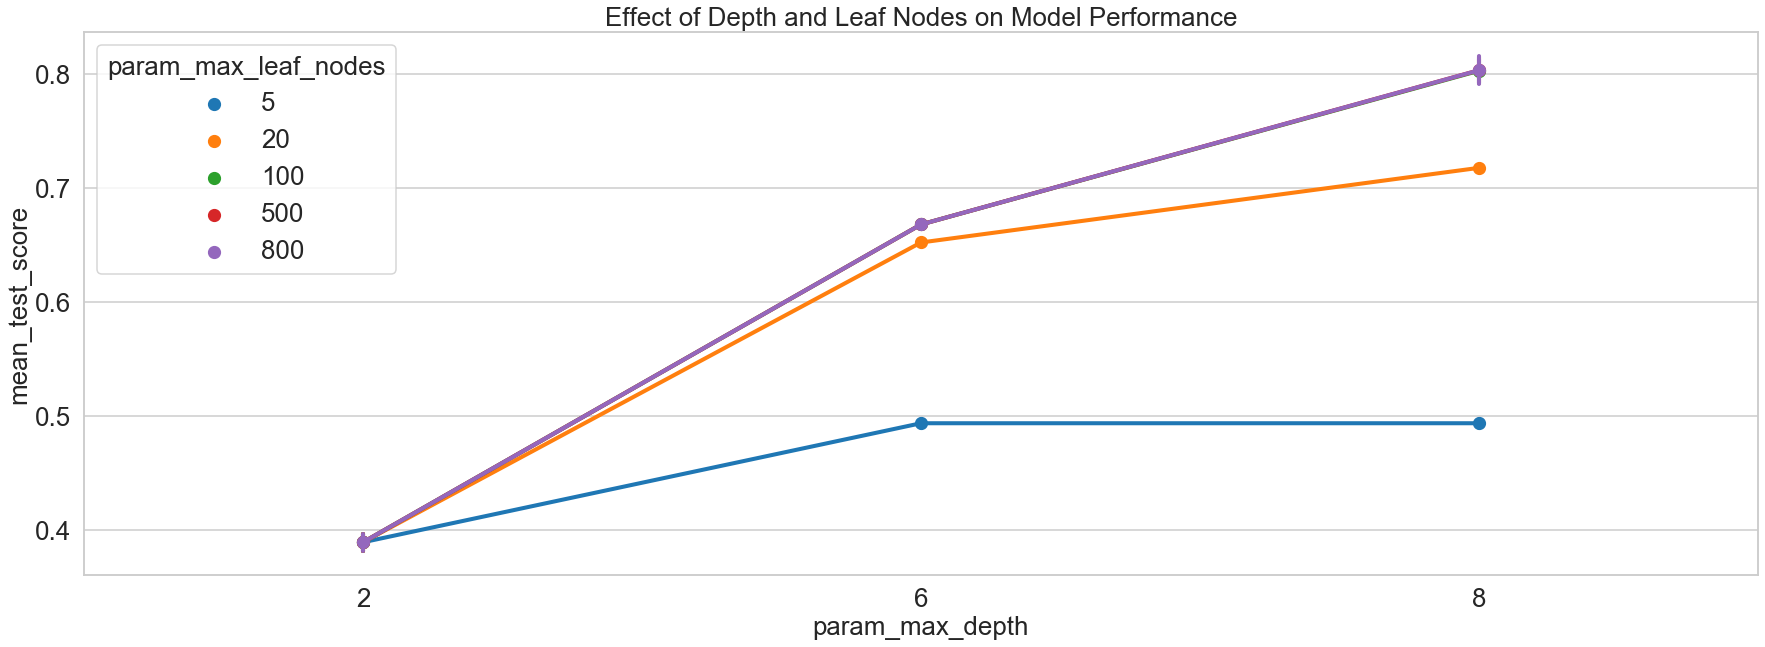

In [20]:
fig,ax = plt.subplots()
sn.pointplot(data=df[['mean_test_score',
                           'param_max_leaf_nodes',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

## Residual Plot

In [21]:
predicted = grid_cv_dtr.best_estimator_.predict(X)
residuals = y.flatten()-predicted

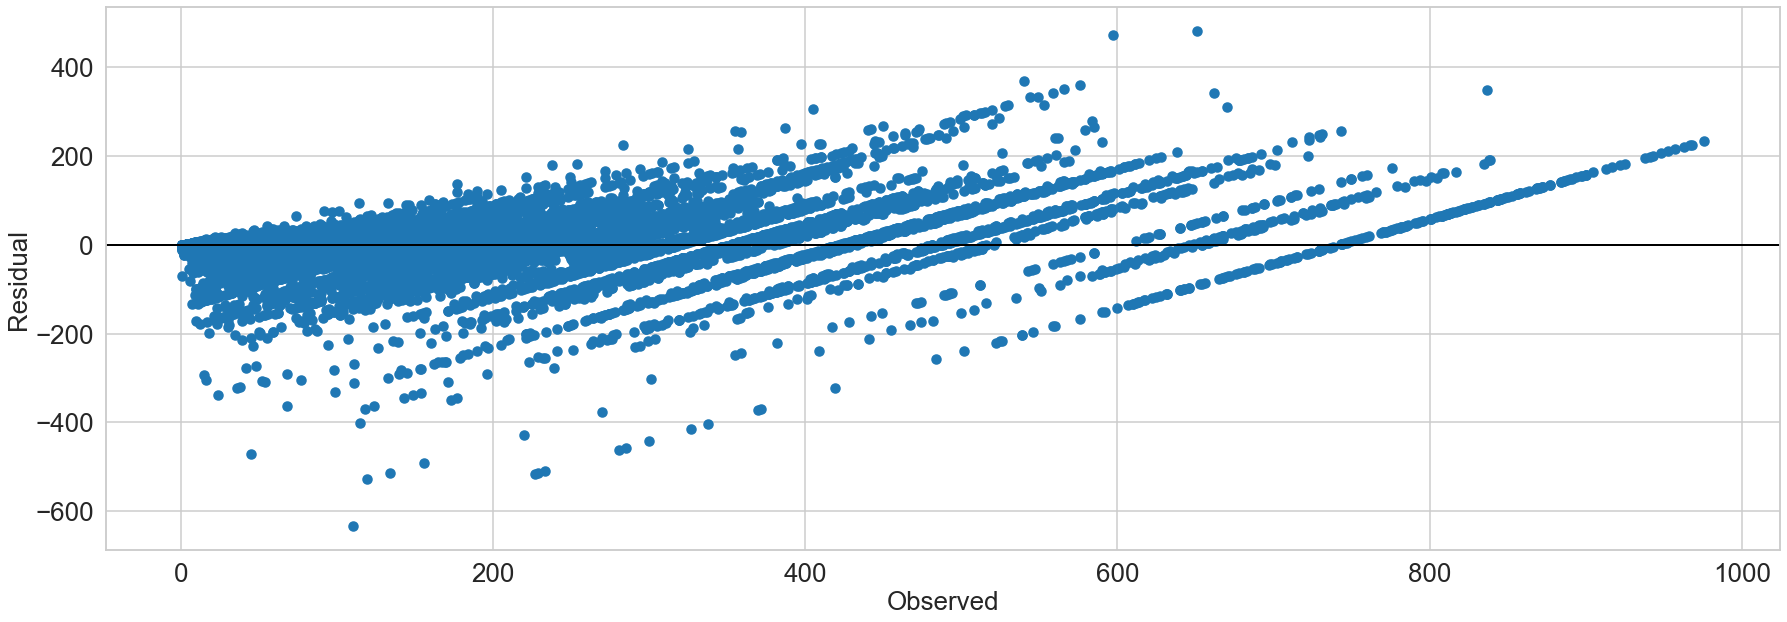

In [25]:
fig, ax = plt.subplots()
ax.scatter(y.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [26]:
r2_scores = cross_val_score(grid_cv_dtr.best_estimator_, X, y, cv=10)
mse_scores = cross_val_score(grid_cv_dtr.best_estimator_, X, y, cv=10,scoring='neg_mean_squared_error')

# Setting the model for Testing

In [27]:
best_dtr_model = grid_cv_dtr.best_estimator_

## Test Dataset Performance

In [29]:
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,le,ohe,col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] for enc in test_encoded_attr_list if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape::{}".format(test_df_new.shape))

Shape::(5736, 19)


In [30]:
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)

In [31]:
y_pred = best_dtr_model.predict(X_test)
residuals = y_test.flatten() - y_pred

In [32]:
r2_score = best_dtr_model.score(X_test,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f"
      % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.847841554250074
MSE: 4854.08


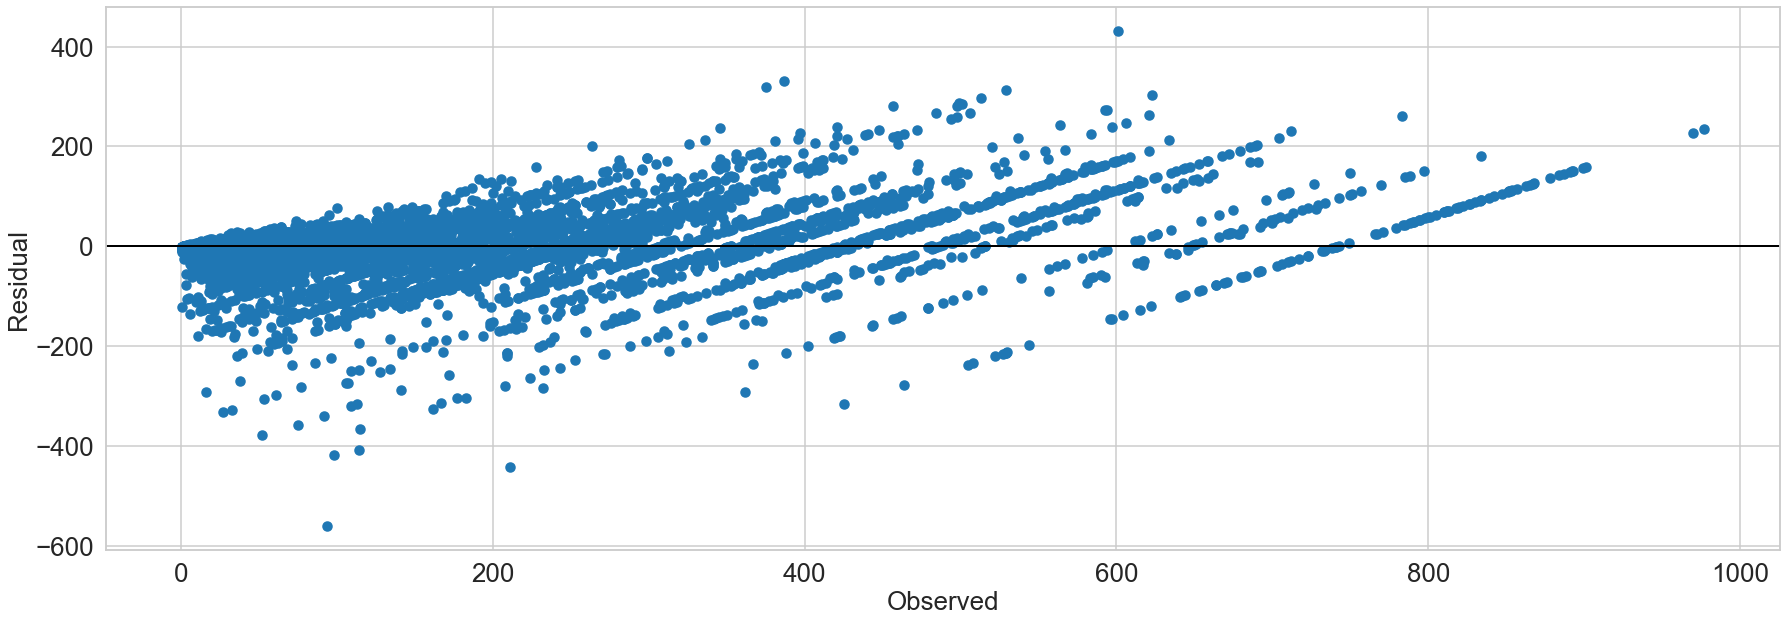

In [33]:
fig, ax = plt.subplots()
ax.scatter(y_test.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

r2_score = grid_cv_dtr.best_estimator_.score(X_test,y_test)